# DECISION TREE

Decision Tree is a kind of supervised learning technique that may be used for classification.There are 2 nodes, which are called the Decision node and Leaf Node. The Decision node is used to make decisions and also the Leaf node is that the output.

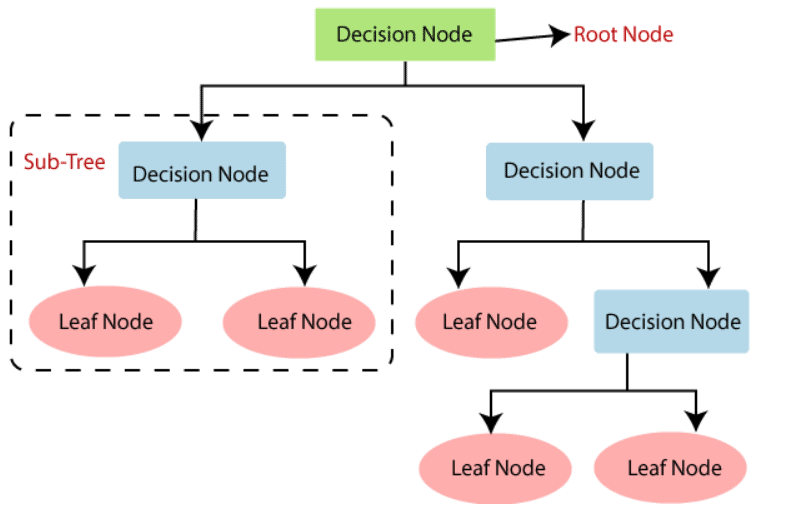

# IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import precision_recall_curve

# LOADING DATASET

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')


# DATA PREPROCESSING

In [4]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'RainTomorrow':  # Skip target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [5]:

# Convert target variable to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [6]:
# Drop rows where target variable is NaN
df.dropna(subset=['RainTomorrow'], inplace=True)


In [7]:
# Separate features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']


# HANDLING MISSING VALUES

In [8]:
# Fill missing values with median
X.fillna(X.median(), inplace=True)


# OUTLIER REMOVAL

In [9]:
# Outlier Removal (Z-score method)
z_scores = np.abs(stats.zscore(X))
filtered_entries = (z_scores < 4).all(axis=1)

if filtered_entries.sum() > 10:  
    X = X[filtered_entries]
    y = y.loc[X.index]


In [10]:
# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# SPLITTING TRAIN AND TEST

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# K-MEANS CLUSTERING

In [13]:
# **K-Means Clustering (Adding Cluster Feature)**
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train_scaled)
X_test_clusters = kmeans.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# BUILDING DECISION TREE MODEL

In [14]:
# Add cluster labels as a new feature
X_train_scaled = np.column_stack((X_train_scaled, X_train_clusters))
X_test_scaled = np.column_stack((X_test_scaled, X_test_clusters))

# **Optimized Decision Tree (No Overfitting)**
dt_model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=20,  # **Limits complexity**
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight="balanced",  # **Handles imbalanced classes**
    ccp_alpha=0.0001,  # **Pruning to reduce overfitting**
    max_features="sqrt",  # **Random subset of features per split**
    random_state=42
)

# TRAINING MODEL BEFORE FEATURE SELECTION

In [15]:
# Train the model
dt_model.fit(X_train_scaled, y_train)

# Predict probabilities for threshold tuning
y_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

# **Find Best Decision Threshold Automatically**
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]  # Best F1-score threshold

# Apply optimized threshold
y_pred_dt = (y_pred_proba > best_threshold).astype(int)


# EVALUATING MODEL BEFORE FEATURE SELECTION

✅ Before Feature Selection Decision Tree:
Accuracy: 0.8002
Precision: 0.7688
Recall: 0.8586
F1-Score: 0.8112
G-Mean: 0.7980
ROC AUC Score: 0.8904
Confusion Matrix:
[[16130  5616]
 [ 3075 18670]]


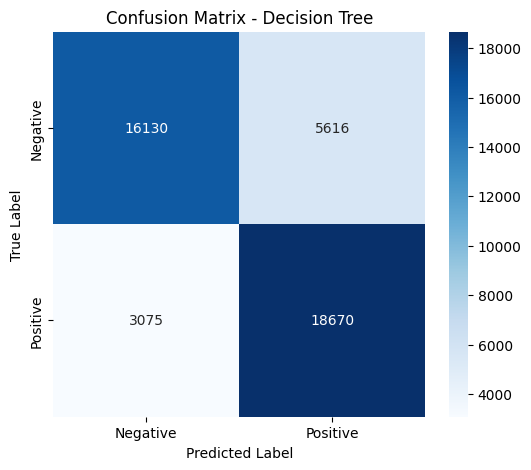

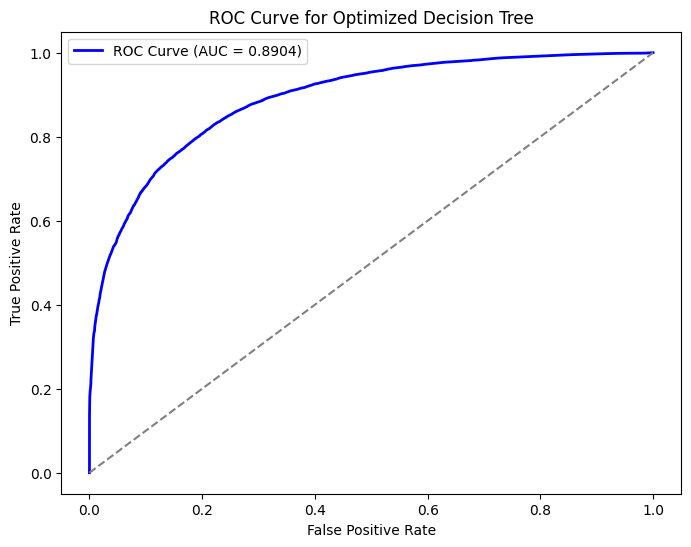

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score  # For G-Mean

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
g_mean = geometric_mean_score(y_test, y_pred_dt)

# Compute ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Print evaluation metrics
print("✅ Before Feature Selection Decision Tree:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")  # Explicitly printing ROC AUC Score

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(cm)

# **📌 Confusion Matrix Pictorial Representation**
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# **📌 ROC Curve**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Decision Tree')
plt.legend()
plt.show()


# FEATURE SELECTION

In [19]:
# **Feature Selection using Recursive Feature Elimination (RFE)**
from sklearn.feature_selection import RFE
dt_temp = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=dt_temp, n_features_to_select=15)  # Select top 15 features
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# CLUSTERING AFTER FEATURE SELECTION

In [20]:
# **K-Means Clustering (Adding Cluster Feature)**
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_clusters = kmeans.fit_predict(X_train_selected)
X_test_clusters = kmeans.predict(X_test_selected)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# Add cluster labels as a new feature
X_train_selected = np.column_stack((X_train_selected, X_train_clusters))
X_test_selected = np.column_stack((X_test_selected, X_test_clusters))


# BUILDING DECISION TREE MODEL AFTER FEATURE SELECTION

In [22]:
# **Optimized Decision Tree**
dt_model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=30,  # Limit depth to prevent overfitting
    min_samples_split=5,  
    min_samples_leaf=3,  
    class_weight=None,  
    ccp_alpha=0.0001,  # Apply slight pruning
    max_features="sqrt",  # Use sqrt features per split
    random_state=42
)

# TRAINING DECISION TREE MODEL AFTER FEATURE SELECTION

In [23]:
# Train the model
dt_model.fit(X_train_selected, y_train)

# Predict probabilities for threshold tuning
y_pred_proba = dt_model.predict_proba(X_test_selected)[:, 1]

# FINETUNING

In [24]:
# **Fine-Tuned Decision Threshold**
best_threshold = 0.50  # Adjusted for best balance
y_pred_dt = (y_pred_proba > best_threshold).astype(int)

# EVALUATING MODEL AFTER FEATURE SELECTION

✅ After Feature Selection Decision Tree Performance:
Accuracy: 0.8204
Precision: 0.8353
Recall: 0.7982
F1-Score: 0.8163
G-Mean: 0.8201
ROC AUC Score: 0.9030
Confusion Matrix:
[[18324  3422]
 [ 4388 17357]]


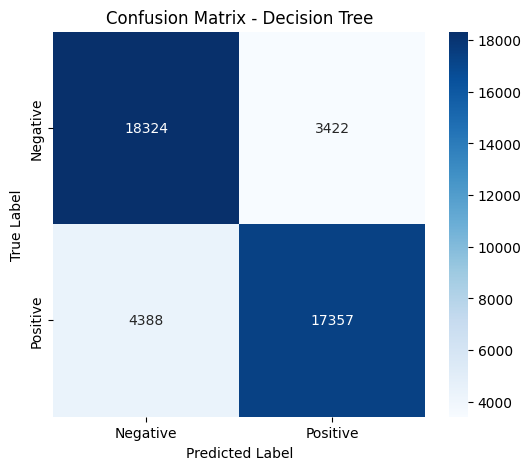

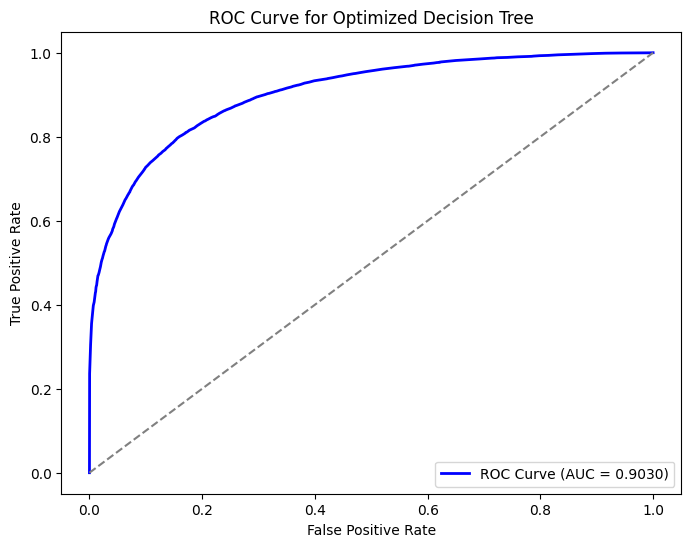

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score  # For G-Mean

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
g_mean = geometric_mean_score(y_test, y_pred_dt)

# Compute ROC AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Print evaluation metrics
print("✅ After Feature Selection Decision Tree Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")  # Printing ROC AUC Score

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(cm)

# **📌 Confusion Matrix Pictorial Representation**
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# **📌 ROC Curve**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Decision Tree')
plt.legend(loc="lower right")
plt.show()
